<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/Plots_TMS_fMRI_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/Plots_TMS_fMRI_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualize TMS-fMRI Simulations: Empirical vs Simulated

Comparison of rasterplots, FC matrices, deltas, and correlation distributions.

## Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import pearsonr, ttest_1samp

print("✓ Imports successful")

Mounted at /content/drive
✓ Imports successful


## Define Paths and Load Data

In [2]:
BASE = "/content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data"

DATASET_EMP_PKL = os.path.join(BASE, "TMS_fMRI", "dataset_tian50_schaefer400_allruns.pkl")
PREPROC_ROOT = os.path.join(BASE, "preprocessed_subjects_tms_fmri")
OUT_DIR = os.path.join(PREPROC_ROOT, "ANN_vs_tms_fmri")

DATASET_SIM_PKL = os.path.join(OUT_DIR, "dataset_simulated_populationANN.pkl")

print("Loading empirical dataset...")
with open(DATASET_EMP_PKL, "rb") as f:
    dataset_emp = pickle.load(f)
print(f"✓ Loaded {len(dataset_emp)} subjects (empirical)")

print("\nLoading simulated dataset...")
with open(DATASET_SIM_PKL, "rb") as f:
    dataset_sim = pickle.load(f)
print(f"✓ Loaded {len(dataset_sim)} subjects (simulated)")

# Get first subject for visualization
example_sub_id = sorted(dataset_emp.keys())[0]
print(f"\n✓ Using subject: {example_sub_id} for visualization")

Loading empirical dataset...


/tmp/ipython-input-3349891921.py:11: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  dataset_emp = pickle.load(f)


✓ Loaded 46 subjects (empirical)

Loading simulated dataset...
✓ Loaded 46 subjects (simulated)

✓ Using subject: sub-NTHC1001 for visualization


## Helper Functions

In [3]:
def safe_target_idx(target_vec):
    """Extract target region index from one-hot vector."""
    if target_vec is None:
        return None
    v = np.asarray(target_vec).astype(int).ravel()
    if v.size == 0 or v.sum() != 1:
        return None
    return int(np.argmax(v))

def seed_based_fc(ts, seed_idx, cortical_only=True):
    """Compute seed-based FC: correlation of seed with all other regions."""
    if cortical_only:
        ts = ts[:, 50:]  # Keep only cortical (Schaefer 400)
        seed_idx = seed_idx - 50  # Adjust seed index (0-399)

    if seed_idx < 0 or seed_idx >= ts.shape[1]:
        return None

    seed_ts = ts[:, seed_idx]  # (T,)
    # Correlate seed with all regions
    corrmat = np.corrcoef(seed_ts, ts.T)  # (1+N, 1+N)
    fc_seed = corrmat[0, 1:]  # (N,) - correlations with all regions
    return fc_seed

def compute_fc_matrix(ts, cortical_only=True):
    """Compute full FC matrix from time series."""
    if cortical_only:
        ts = ts[:, 50:]  # Keep only cortical
    return np.corrcoef(ts.T).astype(np.float32)

print("✓ Helper functions defined")

✓ Helper functions defined


---
# Part 1: Rasterplots (REST and STIM)

In [8]:
# Get REST data for example subject
sub_emp = dataset_emp[example_sub_id]
sub_sim = dataset_sim[example_sub_id]

# Collect rest data
rest_emp_list = []
rest_sim_list = []

for run in sub_emp.get("task-rest", {}).values():
    ts = run.get("time series")
    if isinstance(ts, np.ndarray) and ts.shape[1] >= 450:
        rest_emp_list.append(ts)

for run in sub_sim.get("task-rest", {}).values():
    ts = run.get("time series")
    if isinstance(ts, np.ndarray) and ts.shape[1] >= 450:
        rest_sim_list.append(ts)

# Use first 200 timepoints for visualization
rest_emp = np.concatenate(rest_emp_list, axis=0)[:200]
rest_sim = np.concatenate(rest_sim_list, axis=0)[:200]

# Get STIM data (first stim run)
stim_runs_emp = sub_emp.get("task-stim", {})
stim_runs_sim = sub_sim.get("task-stim", {})

first_stim_idx = list(stim_runs_emp.keys())[0]
stim_emp = stim_runs_emp[first_stim_idx].get("time series")[:200]
stim_sim = stim_runs_sim[first_stim_idx].get("time series")[:200]
target_vec = stim_runs_emp[first_stim_idx].get("target")
target_idx = safe_target_idx(target_vec)

print(f"REST data shapes - Empirical: {rest_emp.shape}, Simulated: {rest_sim.shape}")
print(f"STIM data shapes - Empirical: {stim_emp.shape}, Simulated: {stim_sim.shape}")
print(f"Target region (stimulated): {target_idx}")

REST data shapes - Empirical: (200, 450), Simulated: (200, 450)
STIM data shapes - Empirical: (167, 450), Simulated: (200, 450)
Target region (stimulated): 401


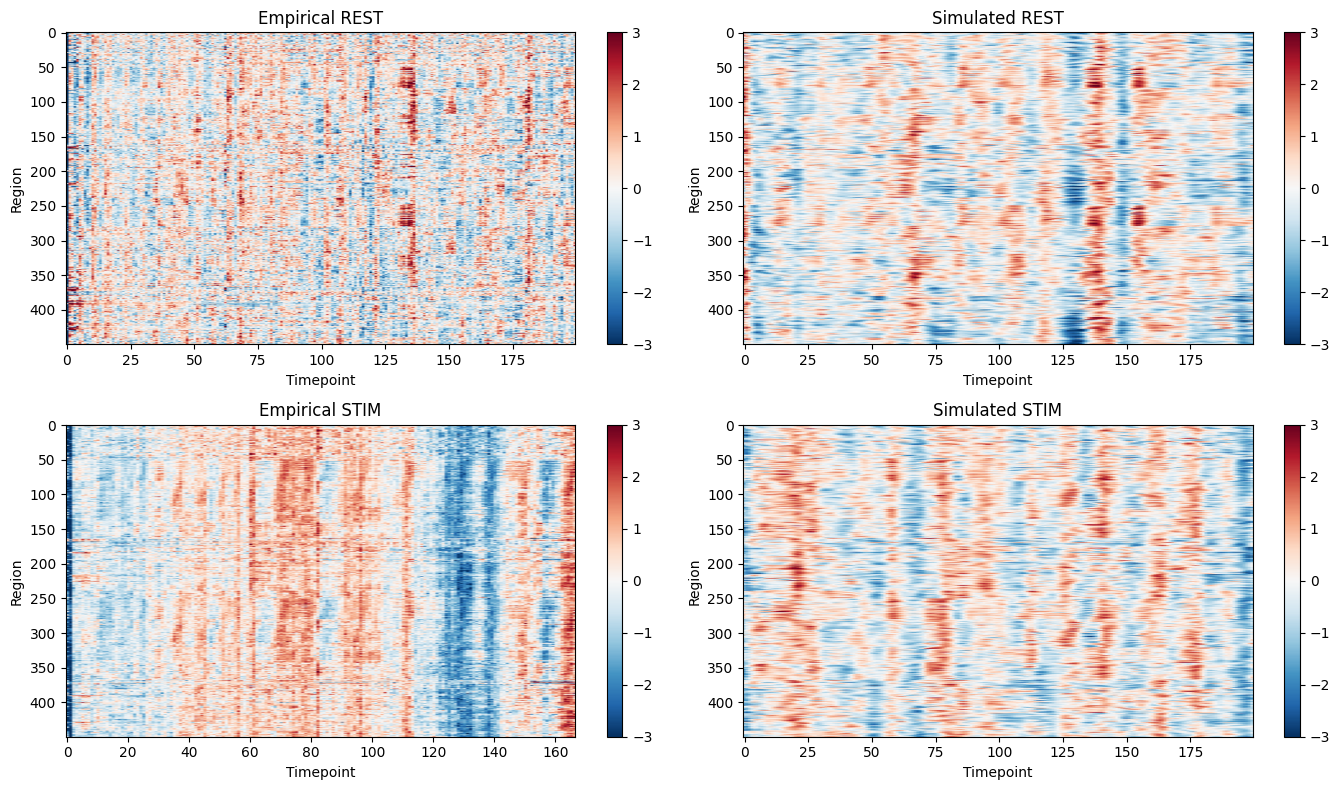

✓ REST rasterplots completed


In [11]:
# Plot rasterplots for REST condition
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
#fig.suptitle(f"Rasterplots: REST Condition ({example_sub_id})", fontsize=14, fontweight='bold')

# Empirical REST
im1 = axes[0, 0].imshow(rest_emp.T, aspect='auto', cmap='RdBu_r', vmin=-3, vmax=3)
axes[0, 0].set_title('Empirical REST')
axes[0, 0].set_ylabel('Region')
axes[0, 0].set_xlabel('Timepoint')
plt.colorbar(im1, ax=axes[0, 0])

# Simulated REST
im2 = axes[0, 1].imshow(rest_sim.T, aspect='auto', cmap='RdBu_r', vmin=-3, vmax=3)
axes[0, 1].set_title('Simulated REST')
axes[0, 1].set_ylabel('Region')
axes[0, 1].set_xlabel('Timepoint')
plt.colorbar(im2, ax=axes[0, 1])

# Empirical STIM
im1 = axes[1, 0].imshow(stim_emp.T, aspect='auto', cmap='RdBu_r', vmin=-3, vmax=3)
axes[1, 0].set_title('Empirical STIM')
axes[1, 0].set_ylabel('Region')
axes[1, 0].set_xlabel('Timepoint')
plt.colorbar(im1, ax=axes[1, 0])

# Simulated STIM
im2 = axes[1, 1].imshow(stim_sim.T, aspect='auto', cmap='RdBu_r', vmin=-3, vmax=3)
axes[1, 1].set_title('Simulated STIM')
axes[1, 1].set_ylabel('Region')
axes[1, 1].set_xlabel('Timepoint')
plt.colorbar(im2, ax=axes[1, 1])

plt.tight_layout()
plt.show()

print(f"✓ REST rasterplots completed")

---
# Part 2: Functional Connectivity (FC) Matrices

In [12]:
# Compute FC matrices for cortical regions only
fc_rest_emp = compute_fc_matrix(rest_emp, cortical_only=True)
fc_rest_sim = compute_fc_matrix(rest_sim, cortical_only=True)

fc_stim_emp = compute_fc_matrix(stim_emp, cortical_only=True)
fc_stim_sim = compute_fc_matrix(stim_sim, cortical_only=True)

print(f"FC matrices shapes: {fc_rest_emp.shape}")
print(f"FC value ranges - REST emp: [{fc_rest_emp.min():.3f}, {fc_rest_emp.max():.3f}]")
print(f"FC value ranges - STIM emp: [{fc_stim_emp.min():.3f}, {fc_stim_emp.max():.3f}]")

FC matrices shapes: (400, 400)
FC value ranges - REST emp: [-0.609, 1.000]
FC value ranges - STIM emp: [-0.435, 1.000]


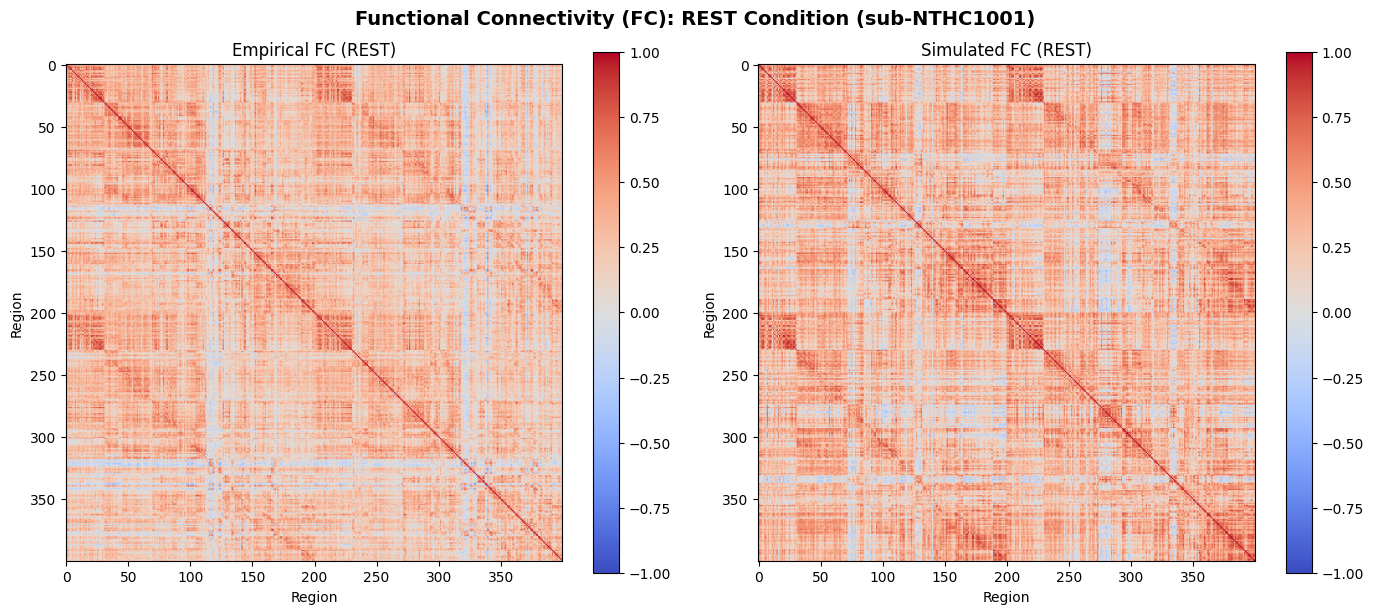

✓ REST FC matrices plotted


In [13]:
# Plot REST FC matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(f"Functional Connectivity (FC): REST Condition ({example_sub_id})", fontsize=14, fontweight='bold')

im1 = axes[0].imshow(fc_rest_emp, cmap='coolwarm', vmin=-1, vmax=1)
axes[0].set_title('Empirical FC (REST)')
axes[0].set_xlabel('Region')
axes[0].set_ylabel('Region')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(fc_rest_sim, cmap='coolwarm', vmin=-1, vmax=1)
axes[1].set_title('Simulated FC (REST)')
axes[1].set_xlabel('Region')
axes[1].set_ylabel('Region')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

print(f"✓ REST FC matrices plotted")

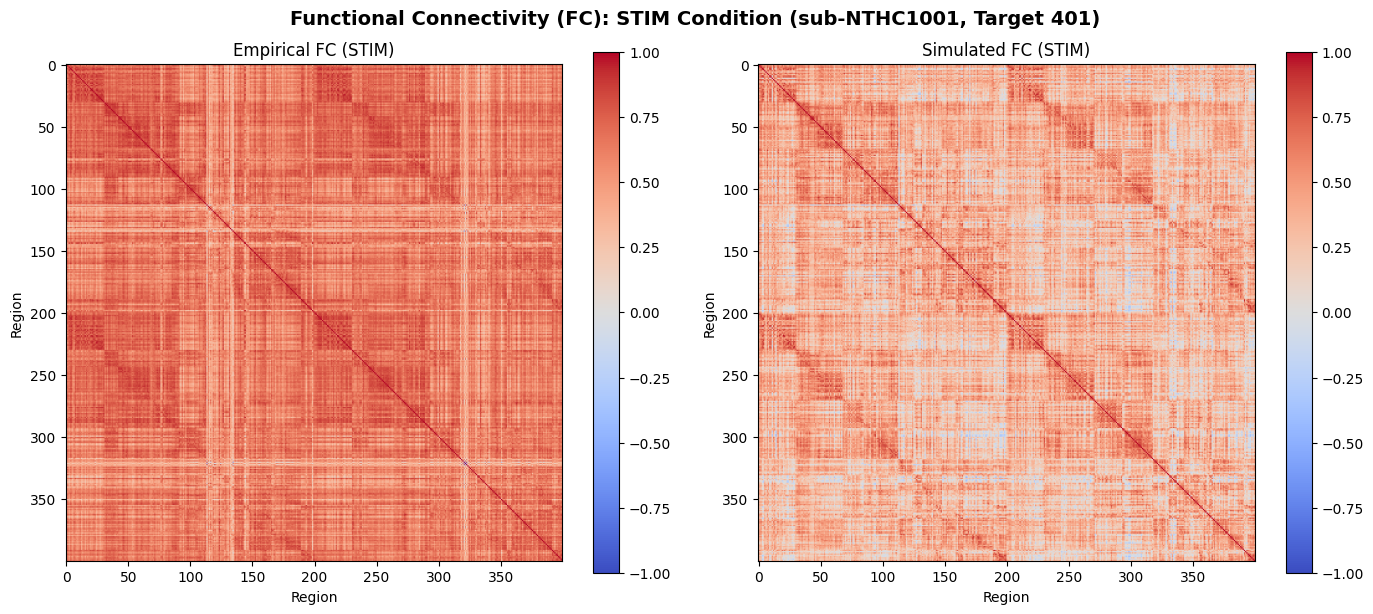

✓ STIM FC matrices plotted


In [14]:
# Plot STIM FC matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(f"Functional Connectivity (FC): STIM Condition ({example_sub_id}, Target {target_idx})", fontsize=14, fontweight='bold')

im1 = axes[0].imshow(fc_stim_emp, cmap='coolwarm', vmin=-1, vmax=1)
axes[0].set_title('Empirical FC (STIM)')
axes[0].set_xlabel('Region')
axes[0].set_ylabel('Region')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(fc_stim_sim, cmap='coolwarm', vmin=-1, vmax=1)
axes[1].set_title('Simulated FC (STIM)')
axes[1].set_xlabel('Region')
axes[1].set_ylabel('Region')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

print(f"✓ STIM FC matrices plotted")

---
# Part 3: Delta FC Matrices (STIM - REST)

In [17]:
# Compute delta FC (STIM - REST)
delta_fc_emp = (fc_stim_emp - fc_rest_emp)/fc_rest_emp
delta_fc_sim = (fc_stim_sim - fc_rest_sim)/fc_rest_sim

print(f"Delta FC ranges - Empirical: [{delta_fc_emp.min():.3f}, {delta_fc_emp.max():.3f}]")
print(f"Delta FC ranges - Simulated: [{delta_fc_sim.min():.3f}, {delta_fc_sim.max():.3f}]")

Delta FC ranges - Empirical: [-9993.595, 22365.461]
Delta FC ranges - Simulated: [-5015.645, 12083.831]


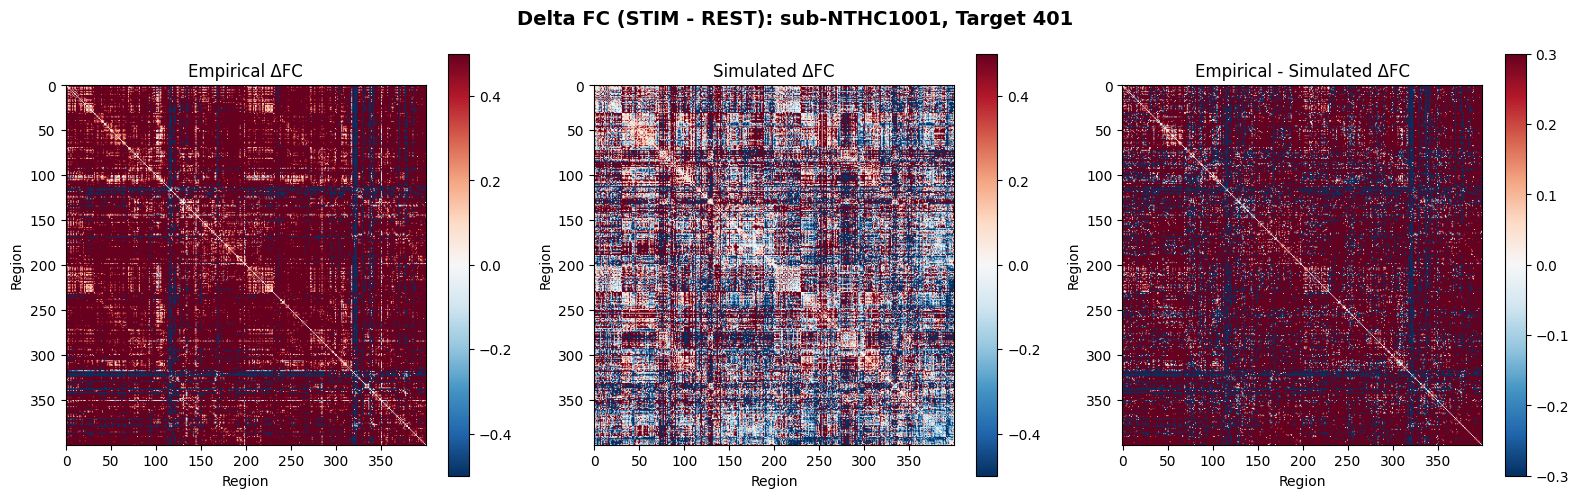

✓ Delta FC matrices plotted


In [18]:
# Plot Delta FC matrices
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle(f"Delta FC (STIM - REST): {example_sub_id}, Target {target_idx}", fontsize=14, fontweight='bold')

# Empirical Delta FC
im1 = axes[0].imshow(delta_fc_emp, cmap='RdBu_r', vmin=-0.5, vmax=0.5)
axes[0].set_title('Empirical ΔFC')
axes[0].set_xlabel('Region')
axes[0].set_ylabel('Region')
plt.colorbar(im1, ax=axes[0])

# Simulated Delta FC
im2 = axes[1].imshow(delta_fc_sim, cmap='RdBu_r', vmin=-0.5, vmax=0.5)
axes[1].set_title('Simulated ΔFC')
axes[1].set_xlabel('Region')
axes[1].set_ylabel('Region')
plt.colorbar(im2, ax=axes[1])

# Difference
im3 = axes[2].imshow(delta_fc_emp - delta_fc_sim, cmap='RdBu_r', vmin=-0.3, vmax=0.3)
axes[2].set_title('Empirical - Simulated ΔFC')
axes[2].set_xlabel('Region')
axes[2].set_ylabel('Region')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

print(f"✓ Delta FC matrices plotted")

---
# Part 4: Correlation Distributions

In [19]:
# Compute seed-based FC correlations across all subjects
print("Computing seed-based correlations across all subjects...\n")

rest_corrs = []
stim_corrs = []
delta_corrs = []

for sub_id in sorted(dataset_emp.keys()):
    if sub_id not in dataset_sim:
        continue

    sub_emp = dataset_emp[sub_id]
    sub_sim = dataset_sim[sub_id]

    # REST
    rest_emp_list = []
    rest_sim_list = []

    for run in sub_emp.get("task-rest", {}).values():
        ts = run.get("time series")
        if isinstance(ts, np.ndarray) and ts.shape[1] >= 450:
            rest_emp_list.append(ts)

    for run in sub_sim.get("task-rest", {}).values():
        ts = run.get("time series")
        if isinstance(ts, np.ndarray) and ts.shape[1] >= 450:
            rest_sim_list.append(ts)

    if not rest_emp_list or not rest_sim_list:
        continue

    rest_emp_sub = np.concatenate(rest_emp_list, axis=0)
    rest_sim_sub = np.concatenate(rest_sim_list, axis=0)

    # STIM
    stim_runs_emp = sub_emp.get("task-stim", {})
    stim_runs_sim = sub_sim.get("task-stim", {})

    if not stim_runs_emp or not stim_runs_sim:
        continue

    for run_idx, run_emp in stim_runs_emp.items():
        run_sim = stim_runs_sim.get(run_idx)
        if run_sim is None:
            continue

        ts_emp = run_emp.get("time series")
        ts_sim = run_sim.get("time series")
        target_vec = run_emp.get("target")

        if not isinstance(ts_emp, np.ndarray) or not isinstance(ts_sim, np.ndarray):
            continue
        if ts_emp.shape[1] < 450 or ts_sim.shape[1] < 450:
            continue

        target_idx_tmp = safe_target_idx(target_vec)
        if target_idx_tmp is None or target_idx_tmp < 50 or target_idx_tmp >= 450:
            continue

        # Seed-based FC using target as seed
        fc_seed_rest_emp = seed_based_fc(rest_emp_sub, target_idx_tmp, cortical_only=True)
        fc_seed_rest_sim = seed_based_fc(rest_sim_sub, target_idx_tmp, cortical_only=True)

        fc_seed_stim_emp = seed_based_fc(ts_emp, target_idx_tmp, cortical_only=True)
        fc_seed_stim_sim = seed_based_fc(ts_sim, target_idx_tmp, cortical_only=True)

        if fc_seed_rest_emp is None or fc_seed_stim_emp is None:
            continue

        # Correlations
        r_rest = np.corrcoef(fc_seed_rest_emp, fc_seed_rest_sim)[0, 1]
        r_stim = np.corrcoef(fc_seed_stim_emp, fc_seed_stim_sim)[0, 1]

        delta_emp = fc_seed_stim_emp - fc_seed_rest_emp
        delta_sim = fc_seed_stim_sim - fc_seed_rest_sim
        r_delta = np.corrcoef(delta_emp, delta_sim)[0, 1]

        if np.isfinite(r_rest):
            rest_corrs.append(r_rest)
        if np.isfinite(r_stim):
            stim_corrs.append(r_stim)
        if np.isfinite(r_delta):
            delta_corrs.append(r_delta)

rest_corrs = np.array(rest_corrs)
stim_corrs = np.array(stim_corrs)
delta_corrs = np.array(delta_corrs)

print(f"REST correlations: {len(rest_corrs)} samples, mean={rest_corrs.mean():.4f}, std={rest_corrs.std():.4f}")
print(f"STIM correlations: {len(stim_corrs)} samples, mean={stim_corrs.mean():.4f}, std={stim_corrs.std():.4f}")
print(f"DELTA correlations: {len(delta_corrs)} samples, mean={delta_corrs.mean():.4f}, std={delta_corrs.std():.4f}")

Computing seed-based correlations across all subjects...

REST correlations: 432 samples, mean=0.4113, std=0.1625
STIM correlations: 432 samples, mean=0.3211, std=0.1628
DELTA correlations: 432 samples, mean=0.0107, std=0.1515


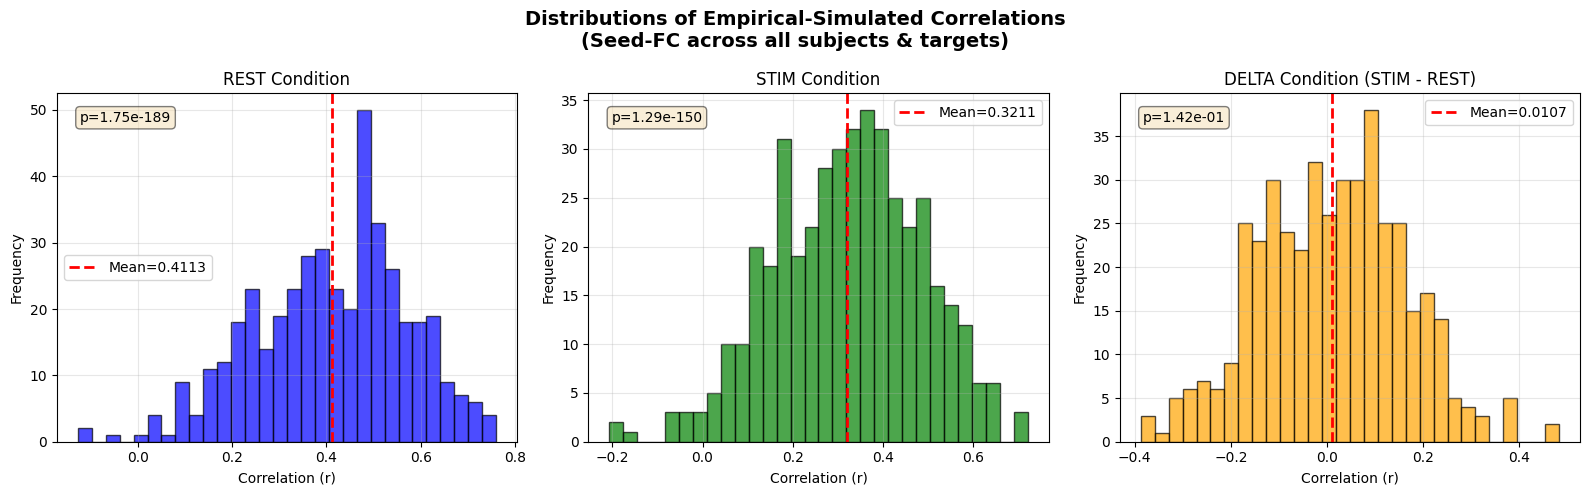

✓ Correlation histograms plotted


In [20]:
# Plot correlation histograms
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("Distributions of Empirical-Simulated Correlations\n(Seed-FC across all subjects & targets)", fontsize=14, fontweight='bold')

# REST
axes[0].hist(rest_corrs, bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(rest_corrs.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean={rest_corrs.mean():.4f}')
axes[0].set_title('REST Condition')
axes[0].set_xlabel('Correlation (r)')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(alpha=0.3)
t_p_rest = ttest_1samp(rest_corrs, 0)[1]
axes[0].text(0.05, 0.95, f'p={t_p_rest:.2e}', transform=axes[0].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# STIM
axes[1].hist(stim_corrs, bins=30, alpha=0.7, color='green', edgecolor='black')
axes[1].axvline(stim_corrs.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean={stim_corrs.mean():.4f}')
axes[1].set_title('STIM Condition')
axes[1].set_xlabel('Correlation (r)')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(alpha=0.3)
t_p_stim = ttest_1samp(stim_corrs, 0)[1]
axes[1].text(0.05, 0.95, f'p={t_p_stim:.2e}', transform=axes[1].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# DELTA
axes[2].hist(delta_corrs, bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[2].axvline(delta_corrs.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean={delta_corrs.mean():.4f}')
axes[2].set_title('DELTA Condition (STIM - REST)')
axes[2].set_xlabel('Correlation (r)')
axes[2].set_ylabel('Frequency')
axes[2].legend()
axes[2].grid(alpha=0.3)
t_p_delta = ttest_1samp(delta_corrs, 0)[1]
axes[2].text(0.05, 0.95, f'p={t_p_delta:.2e}', transform=axes[2].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"✓ Correlation histograms plotted")

In [21]:
# Summary statistics
print("\n" + "="*70)
print("CORRELATION SUMMARY (Empirical vs Simulated)")
print("="*70 + "\n")

for condition, corrs in [('REST', rest_corrs), ('STIM', stim_corrs), ('DELTA', delta_corrs)]:
    t_stat, t_p = ttest_1samp(corrs, 0)
    print(f"{condition:6s}: N={len(corrs):4d}, mean r={corrs.mean():.4f}±{corrs.std():.4f}")
    print(f"        Range: [{corrs.min():.4f}, {corrs.max():.4f}]")
    print(f"        t-test p-value: {t_p:.2e}")
    print(f"        Significant (p<0.05)? {'YES' if t_p < 0.05 else 'NO'}\n")


CORRELATION SUMMARY (Empirical vs Simulated)

REST  : N= 432, mean r=0.4113±0.1625
        Range: [-0.1267, 0.7600]
        t-test p-value: 1.75e-189
        Significant (p<0.05)? YES

STIM  : N= 432, mean r=0.3211±0.1628
        Range: [-0.2067, 0.7208]
        t-test p-value: 1.29e-150
        Significant (p<0.05)? YES

DELTA : N= 432, mean r=0.0107±0.1515
        Range: [-0.3874, 0.4828]
        t-test p-value: 1.42e-01
        Significant (p<0.05)? NO

